In [5]:
import gym
import numpy as np

from gym.spaces import Box

from metadrive.envs.metadrive_env import MetaDriveEnv
from clip.clip_rewarded_sac import CLIPRewardedSAC
from config import CONFIGS

from stable_baselines3 import PPO

CONFIG = CONFIGS["1"]

In [ ]:
from metadrive.obs.image_obs import ImageObservation
from metadrive.obs.observation_base import BaseObservation

class AgentObservation(BaseObservation):
    def __init__(self, config):
        super(AgentObservation, self).__init__(config)
        assert config["norm_pixel"] is False
        assert config["stack_size"] == 1
        self.seg_obs = ImageObservation(config, "seg_camera", config["norm_pixel"])

    @property
    def observation_space(self):
        seg_stack = self.seg_obs.observation_space
        seg_obs_space = Box(low=seg_stack.low.min(), high=seg_stack.high.max(), shape=np.squeeze(seg_stack.shape), dtype=seg_stack.dtype)

        os = dict( # segsem, steer, throttle, speed, relative position of waypoints
            seg=seg_obs_space,
            steer=Box(low=-40, high=40, shape=(1,), dtype=np.float32),
            throttle=Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            speed=Box(low=-80, high=80, shape=(1,), dtype=np.float32),
        )
        return gym.spaces.Dict(os)

    def observe(self, vehicle):
        ret = {}

        seg_cam = self.engine.get_sensor("seg_camera").cam
        agent = seg_cam.getParent()
        original_position = seg_cam.getPos()
        heading, pitch, roll = seg_cam.getHpr()
        seg_img = self.seg_obs.observe(agent, position=original_position, hpr=[heading, pitch, roll])
        assert seg_img.ndim == 4
        assert seg_img.shape[-1] == 1
        assert seg_img.dtype == np.uint8
        seg_img = seg_img[..., 0]
        seg_img = seg_img[..., ::-1]  # BGR -> RGB
        ret["seg"] = seg_img

        ego = self.engine.get_sensor("ego")
        steer, throttle, speed = ego.perceive()

        ret["steer"] = np.array([steer], dtype=np.float32)
        ret["throttle"] = np.array([throttle], dtype=np.float32)
        ret["speed"] = np.array([speed], dtype=np.float32)

        return ret

In [ ]:
from custom import SegCamera, EgoState, WaypointSensor

sensors = dict(
    seg_camera=(SegCamera, 100, 100),
    ego=(EgoState, 'default_agent'),
    waypoint=(WaypointSensor, 'default_agent', 15),
)

env_cfg = dict(
    agent_observation=AgentObservation,

    # Image rendering
    image_observation=True,
    norm_pixel=False,
    stack_size=1,

    # Sensors
    sensors=sensors
)

### Extra just for dimension testing

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), seg_camera: SegCamera(100, 100), imu: IMU(None,)]
[INFO] Render Mode: offscreen
[INFO] Horizon (Max steps per agent): 1000
[WARNING] You have set norm_pixel = False, which means the observation will be uint8 values in [0, 255]. Please make sure you have parsed them later before feeding them to network! (metadrive_env.py:117)
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: CocoaGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


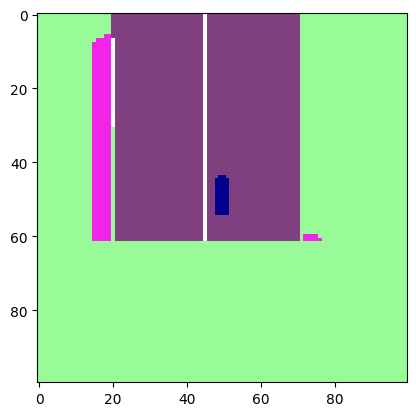

In [6]:
import matplotlib.pyplot as plt

env = MetaDriveEnv(env_cfg)

obs, info = env.reset()
agent = env.agent
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

plt.imshow(obs["seg"])

env.close()

In [5]:
env.close()